In [1]:
from datetime import datetime
import json
import os

from IPython.display import JSON
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import s3fs

os.environ['AWS_PROFILE'] = 'waisman-admin'


In [2]:
s3 = s3fs.S3FileSystem()
def convert_json(s):
    s = s.replace('\'', '"').replace('False', 'false').replace('True', 'true')
    s_json = json.loads(s)
    s_json['Timestamp'] = datetime.strptime(s_json['Timestamp'], '%Y-%m-%d %H:%M:%S.%f')  # Convert to datetime
    return s_json
with s3.open('s3://nkalafut-celltrip/logs/3gpu-2learn-6run-20iter.log', 'r') as f:
    records = f.read().split('\n')
    records = [convert_json(record) for record in records if len(record) > 0]
assert len(records) != 0, 'Logfile is empty! If currently running, try waiting for flush'


In [ ]:
# Generate df
df = pd.DataFrame(records)
for col in ('Itemized Reward', 'Losses'):
    try: df = pd.concat((df.drop(columns=col), pd.json_normalize(df[col])), axis=1)
    except: print(f'Column {col} not found, might be missing some event types. '
                  f'This is expected if running early in training.')
begin_time = df.loc[df['Event Type']=='Register Workers', 'Timestamp'].item()
df['Timestamp'] = df['Timestamp'].apply(lambda t: (t-begin_time).total_seconds() / 60**1)  # Minutes


In [4]:
# Event filter
def event_filter(event_type):
    return (df
        .loc[df['Event Type'] == event_type]
        .dropna(axis=1).drop(columns=['Event Type']))

def group_policy(df):
    return (df
        .drop(columns=['Rank'])
        .groupby('Policy Iteration').mean())

In [ ]:
group_policy(event_filter('Update'))

,Timestamp,Time,New Memories,Replay Memories,Total Memories,Iterations,Action STD,PPO,critic,entropy,KL
Policy Iteration,,,,,,,,,,,
1.0,0.817452,30.449328,120000.0,0.0,120000.0,80.0,0.606296,-0.006085,1.033420e+06,-0.027543,0.002176
2.0,1.632346,30.450911,120000.0,120000.0,240000.0,80.0,0.609193,-0.008016,1.095569e+06,-0.027686,0.001615
3.0,2.452427,30.667567,120000.0,240000.0,360000.0,80.0,0.614688,-0.007403,8.161708e+05,-0.027962,0.002309
4.0,3.277164,30.625060,120000.0,360000.0,480000.0,80.0,0.619477,-0.006958,8.070619e+05,-0.028204,0.002452
5.0,4.109810,31.047477,120000.0,480000.0,600000.0,80.0,0.625071,-0.007017,9.052272e+05,-0.028486,0.002913
6.0,4.940019,31.105274,120000.0,600000.0,720000.0,80.0,0.630027,-0.005599,8.381057e+05,-0.028700,0.002739
7.0,5.774325,30.926397,120000.0,720000.0,840000.0,80.0,0.636410,-0.006623,1.158941e+06,-0.029007,0.003280
8.0,6.609067,30.833961,120000.0,840000.0,960000.0,80.0,0.639442,-0.006514,8.905078e+05,-0.029158,0.002618
9.0,7.449908,31.113675,120000.0,960000.0,1080000.0,80.0,0.638422,-0.006436,6.319976e+05,-0.029102,0.001796


In [ ]:
group_policy(event_filter('Rollout'))

,Timestamp,Timesteps,Memories,Reward,Time,distance,origin,bound,velocity,action
Policy Iteration,,,,,,,,,,
0.0,0.165243,1000.0,20000.0,-6.794221,9.914004,-4.243726,0.0,-0.315500,-1.867809,-0.367188
1.0,0.978304,1000.0,20000.0,-5.892422,9.326770,-3.170865,0.0,-0.316733,-2.028932,-0.375899
2.0,1.794063,1000.0,20000.0,-3.490874,9.370646,-0.913980,0.0,-0.341316,-1.853132,-0.382447
3.0,2.614170,1000.0,20000.0,-3.100137,9.370871,-0.499979,0.0,-0.335817,-1.874836,-0.389501
4.0,3.439479,1000.0,20000.0,-3.031532,9.401413,-0.407899,0.0,-0.341300,-1.885619,-0.396719
5.0,4.272436,1000.0,20000.0,-2.917623,9.413617,-0.345984,0.0,-0.327683,-1.842249,-0.401713
6.0,5.103489,1000.0,20000.0,-2.849144,9.467073,-0.196008,0.0,-0.368000,-1.873114,-0.412029
7.0,5.937412,1000.0,20000.0,-3.012813,9.433452,-0.239769,0.0,-0.292517,-2.065105,-0.415422
8.0,6.771842,1000.0,20000.0,-2.687709,9.421123,-0.172801,0.0,-0.300700,-1.791163,-0.423043


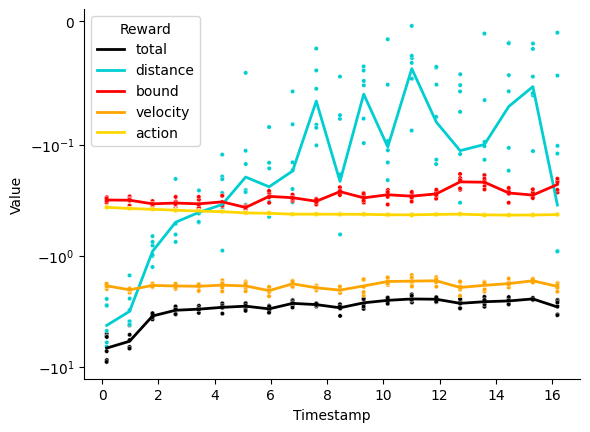

In [ ]:
def melt_rewards(df):
    return df[
        ['Timestamp', 'Reward', 'distance',  # 'origin',
        'bound', 'velocity', 'action']].rename(
            columns={'Reward': 'total'}
        ).melt(
            id_vars='Timestamp', var_name='Reward',
            value_name='Value')

fig, ax = plt.subplots(1, 1)
reward_colors = {
    'total': 'black', 'distance': 'darkturquoise',
    'origin': 'darkolivegreen', 'bound': 'red',
    'velocity': 'orange', 'action': 'gold'}
sns.lineplot(
    melt_rewards(group_policy(event_filter('Rollout'))),
    x='Timestamp', y='Value', hue='Reward', palette=reward_colors,
    lw=2, ax=ax)
sns.scatterplot(
    melt_rewards(event_filter('Rollout')), x='Timestamp',
    y='Value', hue='Reward', palette=reward_colors, s=10,
    legend=False, ax=ax)
sns.despine(ax=ax)
ax.set_xlim(left=0)
ax.set_yscale('symlog', linthresh=.1)
